In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import joblib

In [2]:
# Simulate Health Data

np.random.seed(42)
data = pd.DataFrame({
    'temperature': np.random.normal(38.5, 0.5, 100),
    'heart_rate': np.random.normal(80, 10, 100),
    'respiratory_rate': np.random.normal(30, 5, 100),
    'is_sick': np.random.choice([0, 1], size=100, p=[0.85, 0.15])
})
data['health_index'] = data['temperature'] * 0.3 + data['heart_rate'] * 0.4 + data['respiratory_rate'] * 0.3

In [3]:
# Explore the Data

print(data.head())
print(data.describe())

   temperature  heart_rate  respiratory_rate  is_sick  health_index
0    38.748357   65.846293         31.788937        0     47.499705
1    38.430868   75.793547         32.803923        0     51.687856
2    38.823844   76.572855         35.415256        0     52.900872
3    39.261515   71.977227         35.269010        0     51.150048
4    38.382923   78.387143         23.111653        1     49.803230
       temperature  heart_rate  respiratory_rate    is_sick  health_index
count   100.000000  100.000000        100.000000  100.00000    100.000000
mean     38.448077   80.223046         30.324481    0.21000     52.720986
std       0.454084    9.536690          5.421414    0.40936      4.087028
min      37.190127   60.812288         13.793663    0.00000     44.309810
25%      38.199547   71.943395         26.722782    0.00000     50.076907
50%      38.436522   80.841072         30.488479    0.00000     52.634886
75%      38.702976   85.381704         33.522187    0.00000     54.874616


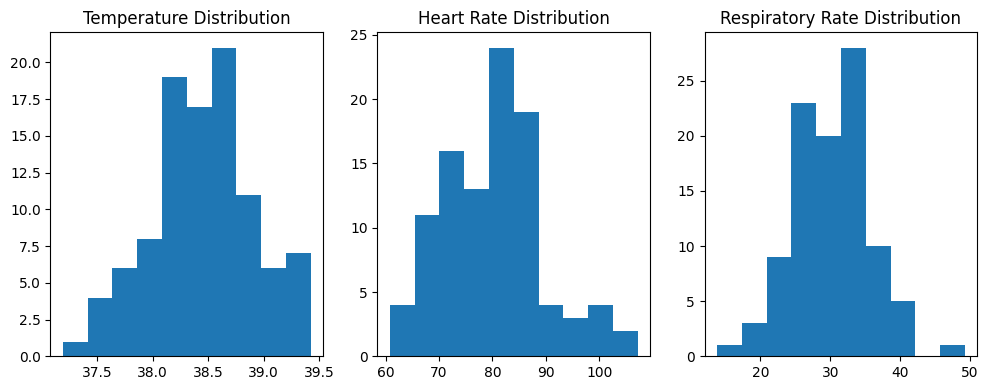

In [4]:
#  Visualize Distributions

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.hist(data['temperature'], bins=10)
plt.title('Temperature Distribution')

plt.subplot(1, 3, 2)
plt.hist(data['heart_rate'], bins=10)
plt.title('Heart Rate Distribution')

plt.subplot(1, 3, 3)
plt.hist(data['respiratory_rate'], bins=10)
plt.title('Respiratory Rate Distribution')

plt.tight_layout()
plt.show()

In [5]:
# Train-Test Split

X = data[['temperature', 'heart_rate', 'respiratory_rate', 'health_index']]
y = data['is_sick']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Handle Class Imbalance with SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts())

Before SMOTE: is_sick
0    63
1    17
Name: count, dtype: int64
After SMOTE: is_sick
1    63
0    63
Name: count, dtype: int64


In [7]:
# Feature Scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Grid Search for Best Parameters

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_scaled, y_train_resampled)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [5, 10, None], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='f1', verbose=1)

Classification Report (GridSearch best model):
              precision    recall  f1-score   support

           0       0.90      0.56      0.69        16
           1       0.30      0.75      0.43         4

    accuracy                           0.60        20
   macro avg       0.60      0.66      0.56        20
weighted avg       0.78      0.60      0.64        20



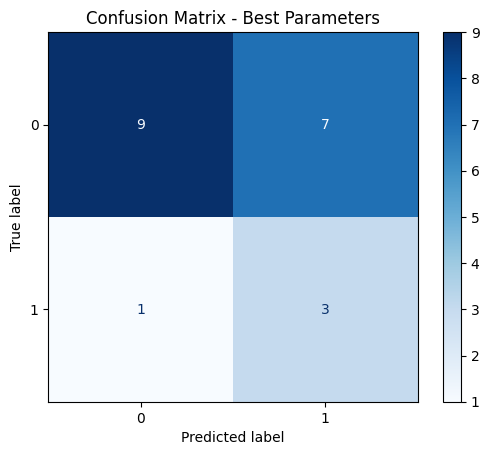

In [9]:
# Get Best Model & Evaluate

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_scaled)
print("Classification Report (GridSearch best model):")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test, cmap='Blues')
plt.title("Confusion Matrix - Best Parameters")
plt.show()

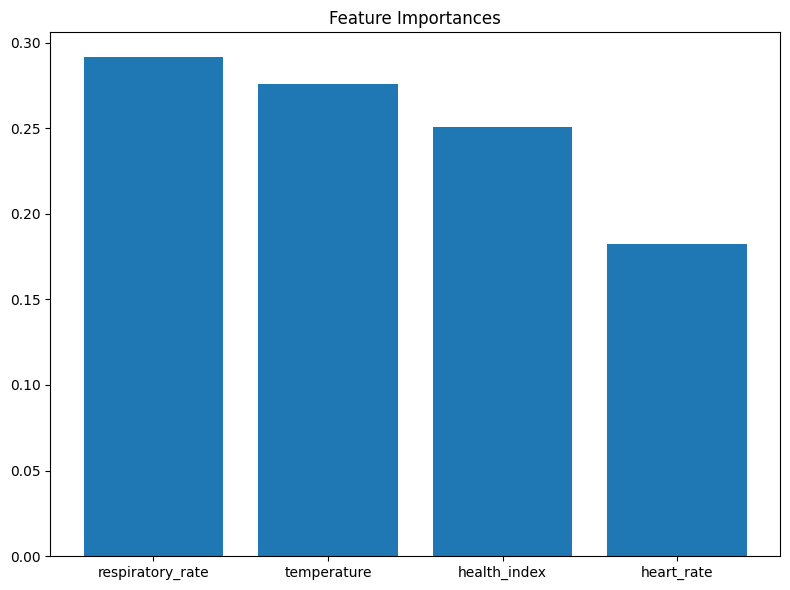

In [10]:
# Feature Importances

importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices])
plt.tight_layout()
plt.show()

In [11]:
# Save Model

joblib.dump(best_model, 'livestock_health_model.pkl')

['livestock_health_model.pkl']